In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

pd.set_option('display.max_rows', 2000)

In [2]:
red_wine_df = pd.read_csv("resources/winequality-red.csv", sep=';')

In [3]:
print("lenght =", len(red_wine_df))
red_wine_df.head()

lenght = 1599


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### V.1 Exploring the green reds

#### a) Plot scatter matrix function

In [4]:
def plot_scatter_matrix(data, good_threshold, bad_threshold, rows=12, cols=12, save_plot=False, name=None):
    fig, axmat = plt.subplots(rows, cols, figsize=(20, 20))
    for axrow in axmat:
        for ax in axrow:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    h_list = data.columns.values
    for i in range(len(h_list)):
        for j in range(len(h_list)):
            plt.sca(axmat[i][j])
            if (i == j):
                plt.text(0.5, 0.5, h_list[j].replace(' ', '\n'), fontsize=16, ha='center', va='center')
            else:
                plt.scatter(data[h_list[j]][data['quality'] > good_threshold],
                            data[h_list[i]][data['quality'] > good_threshold], s=3, c='g')
                plt.scatter(data[h_list[j]][data['quality'] < bad_threshold],
                            data[h_list[i]][data['quality'] < bad_threshold], s=3, c='m')
    if (save_plot):
        if (name == None):
            plt.savefig('Plt.png')
        else:
            plt.savefig("{}.png".format(name))
    plt.show()

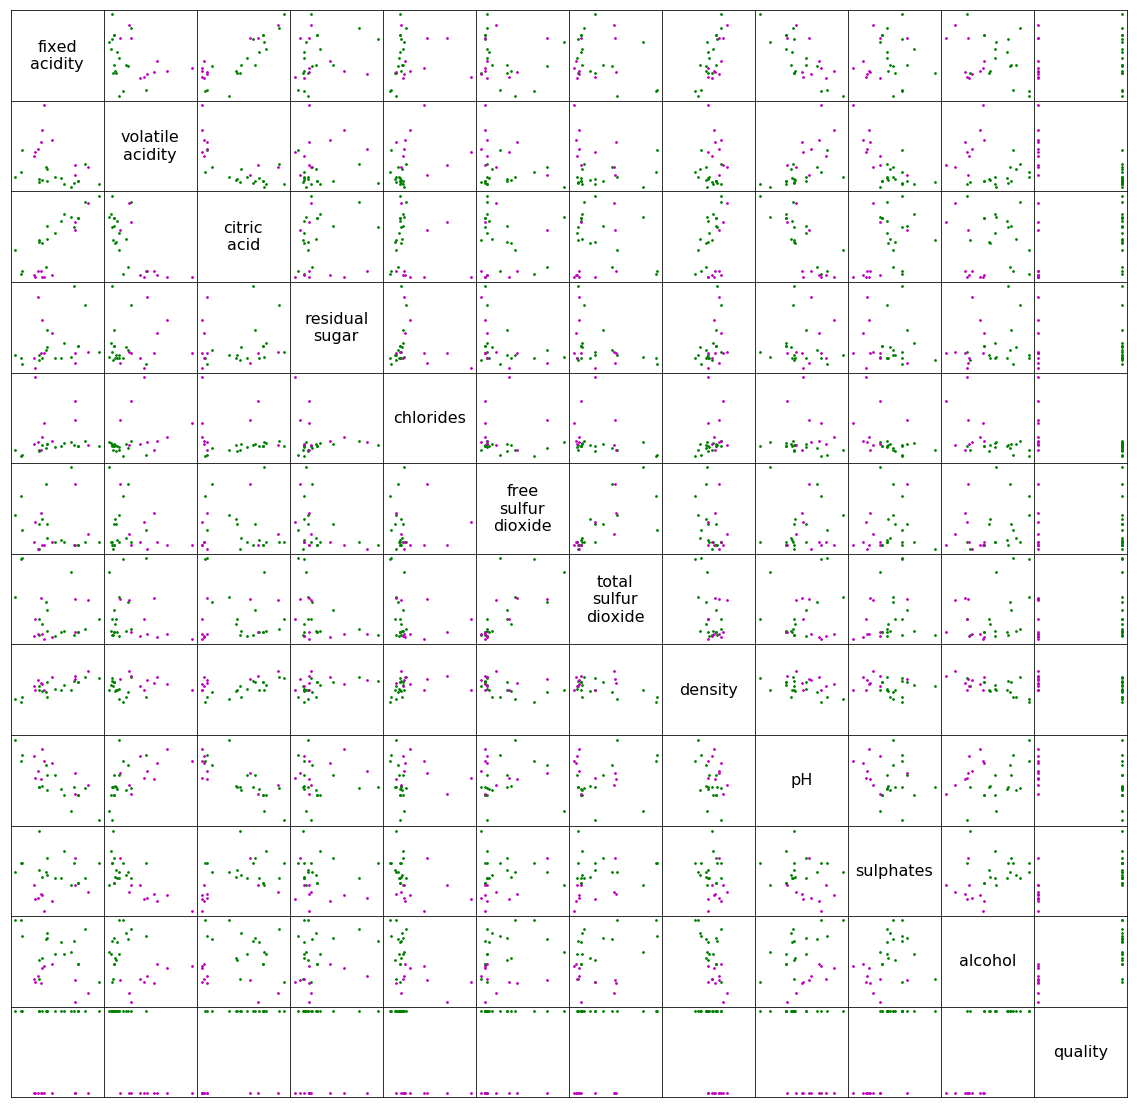

In [5]:
plot_scatter_matrix(red_wine_df, 7, 4)

#### b) Which factors do you think will be most useful for distinguishing high vs low quality wines

At a first glance I see that pH and alcohol have a clearer division when it comes to quality. We can plot a decision boundary that will divide the data perfectly using these 2 features. This is the case when comparing high quality wines (8 or higher) vs low quality wines (3 or lower)

### V.2 Learning to perceptron

#### a)&b) Perceptron implementation and training

In [6]:
def select_features_labels(data, good_thres=7, bad_thres=4, features_list=["pH", "alcohol"], labels=(1, 0)):
    tmp = data[features_list + ["quality"]][(
        data['quality'] > good_thres) | (data['quality'] < bad_thres)]
    tmp['quality'].where(tmp['quality'] < bad_thres, labels[0], inplace=True)
    tmp['quality'].where(tmp['quality'] == 1, labels[1], inplace=True)
    features = tmp[features_list].values
    labels = tmp['quality'].values
    return (features, labels)

In [7]:
class Perceptron:
    def __init__(self, input_size):
        self.weights = [0] * input_size
        for i in range(input_size):
            self.weights[i] = random.uniform(-1, 1)
        self.bias = random.uniform(-1, 1)
    def heaviside_step_fn(nb):
        if (nb >= 0):
            return (1)
        else:
            return (0)
    def forward_pass(self, X):
        return (self.heaviside_step_fn(sum(self.weights * X) + self.bias))
    def evaluate(self, features, labels):
        errors = 0
        for X, y in zip(features, labels):
            output = self.forward_pass(X)
            if (output != y):
                error += 1
        return (errors)
    def train(self, data, l_rate, epochs):
        features, labels = select_features_labels(data)
        if (epochs == 0):
            epochs = 1000000
        perf = [0, self.evaluate(features, labels), self.weights, self.bias]
        for epoch in range(1, epochs + 1):
            for X, y in zip(features, labels):
                output = self.forward_pass(X)